# Machine Learning-Based Volatility Prediction

<b>ความผันผวน (Volatility) </b> ถูกใช้ในการคาดการณ์ความไม่สม่ำเสมอของตลาด ใน Financial Market นั้นเปรียบเสมือนเป็นกระดูกสันหลัง (backbone) เลยก็ว่าได้ และเนื่องจากการเราไม่สามารถใช้ราคา (Price) มาเป็น Lag ในการวิเคราะห์ Asset ใดๆก็ตาม ได้โดยตรง ทั้งนี้เป็นเพราะว่า เมื่อเวลาผ่านไป Asset นั้นๆจะมีราคาเปลี่ยนแปลงไปทำให้ข้อมูลไม่มีความยืดหยุ่นพอที่จะมาวิเคราะห์ตลาดได้อย่างต่อเนื่อง แต่หากเราใช้ผลตอบแทนรายวัน (Daily Return) มาเป็นตัวแทนข้อมูล เราจะได้ข้อมูลที่มีความยืดหยุ่นและมีความต่อเนื่องตั้งแต่อดีตมาจนถึงปัจจุบัน ซึ่งเป็นประโยชน์อย่างมากในการนำไปต่อยอดวิเคราะห์ความผันผวนในตลาดนั่นเอง

สำหรับ Dataset นั้นจะอาศัยการดึงข้อมูลจาก Open API ของ Cryptocurrency Exchange ชื่อดังอย่าง Binance โดยในที่นี้จะดึงราคา Bitcoin บน Timeframe 1 Hour ย้อนหลังตั้งแต่ 1 Dec 2018 ไปจนถึง 1 Nov 2021 จากนั้นจะทำการ Perform และ Resample ข้อมูลตามช่วงเวลา เพื่อหา Returns จากราคาปิด (Closed Price) เพื่อให้ได้มาซึ่งข้อมูลสำหรับนำไป Train และ Test โมเดล

In [1]:
import pandas as pd
import numpy as np
from binance.client import Client
from keys import *
import datetime

from scipy.stats import norm
import scipy.optimize as opt
import time
from arch import arch_model
import matplotlib.pyplot as plt
from numba import jit
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

# Load binance api secrete keys
client = Client(key1, key2)

In [2]:
# Load crypto historical data  
klines = client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1HOUR, "1 Dec, 2018", "1 Nov, 2021")
df = pd.DataFrame(klines, columns = ['ot', 'open', 'high', 'low', 'close', 'volume', 'ct', 'qsv', 'no_trade', 'tbav', 'tbqv', 'ign'])

df.head(2).append(df.tail(2))

,ot,open,high,low,close,volume,ct,qsv,no_trade,tbav,tbqv,ign
0,1543622400000,4041.27000000,4048.00000000,4009.19000000,4043.58000000,1074.10528700,1543625999999,4326719.65187396,5924,598.01061600,2409164.15044035,0
1,1543626000000,4044.84000000,4063.40000000,4038.00000000,4047.29000000,1057.30766600,1543629599999,4284271.09157118,5616,534.37722200,2165230.10589711,0
25525,1635721200000,61365.72000000,61620.06000000,61170.19000000,61299.80000000,947.29370000,1635724799999,58157286.89140300,32902,494.69553000,30372568.06130130,0
25526,1635724800000,61299.81000000,61660.27000000,61115.33000000,61560.49000000,1423.33658000,1635728399999,87460568.53074420,52006,698.21070000,42899789.92090920,0


In [3]:
# Perform dataframe with selected data and datetime
perf = df.loc[:, ['ct', 'close', 'volume']].set_index(['ct'])
perf.index = pd.to_datetime(perf.index, unit='ms')

In [4]:
# Transform pandas object value to numeric 
perf["close"] = pd.to_numeric(perf["close"])
perf["volume"] = pd.to_numeric(perf["volume"])

## Daily Volatility & Variance

ใน Financial Market นั้น ความผันผวน (Volatility : $\large \sigma $) มีความยืดหยุ่นในการวิเคราะห์มากกว่า Price จึงเป็นที่มาของการวิเคราะห์ความผันผวน <br><br>
ในทางการเงินนั้น Volatility คือ ระดับของความผันผวนของ Trading Price (ในที่นี้ใช้ Closed Price) ในช่วงเวลาหนึ่ง ที่วัดค่าโดย Standard Deviation ของ Log Return <br><br>
$\large \sigma = \sqrt{\frac{1}{n-1}\sum_{i=1}^{n}(\bar{r}-r_i)^{2}} $
<br><br> $\sigma$ = volatility
<br> $\bar{r}$ = mean log return
<br> $r_i$ = log return at time i
<br> $n$ = number of log return observations

Volatility = $\sqrt{Variance}$ = Standard Deviation <br><br>
Volatility นั้นเป็น Subjective Term ขณะที่ Variance เป็น Objective Term เช่น เราสามารถหา Variance จากข้อมูลได้ แต่เราไม่สามารถหา Volatility จากข้อมูลได้ ซึ่ง Volatility นั้นจะเกี่ยวโยงกับความไม่แน่นอนของกระบวนการ ซึ่งค่านี้ก็ขึ้นอยู่กับการประมาณการ ไม่มีค่าตายตัว (Typically Unobservable) <br><br>
<b>Equally as important as the forecast methodology is the proxy of variance that one measures performance against.</b>

In [5]:
# Resample to hour data
h_df = pd.DataFrame(perf.loc[:, ['close', 'volume']]).resample('H', closed='left', label='left').mean().copy()
h_df['log_price'] = np.log(h_df['close'].astype(float))
h_df['return'] = h_df['close'].astype(float).pct_change().dropna()
h_df['log_return'] = h_df['log_price'] - h_df['log_price'].shift(1)
h_df['squared_log_return'] = np.power(h_df['log_return'], 2)

# Scale up 10x
h_df['return_10x'] = np.multiply(h_df['return'], 10)
h_df['log_return_10x'] = np.multiply(h_df['log_return'], 10)

h_df.head()

,close,volume,log_price,return,log_return,squared_log_return,return_10x,log_return_10x
ct,,,,,,,,
2018-12-01 00:00:00,4043.58,1074.105287,8.304886,NaN,NaN,NaN,NaN,NaN
2018-12-01 01:00:00,4047.29,1057.307666,8.305803,0.000918,0.000917,8.410415e-07,0.009175,0.009171
2018-12-01 02:00:00,4019.99,1036.377432,8.299035,-0.006745,-0.006768,4.580726e-05,-0.067453,-0.067681
2018-12-01 03:00:00,4030.39,867.485738,8.301618,0.002587,0.002584,6.675663e-06,0.025871,0.025837
2018-12-01 04:00:00,4004.46,1527.692107,8.295164,-0.006434,-0.006454,4.165935e-05,-0.064336,-0.064544


In [6]:
# Resample to 5-hours data
five_h_df = pd.DataFrame(h_df.loc[:, ['close', 'volume']], index=h_df.index).resample('5H', closed='left', label='left').mean().copy()
five_h_df['log_price'] = np.log(five_h_df['close'].astype(float))
five_h_df['log_return'] = five_h_df['log_price'] - five_h_df['log_price'].shift(1)
five_h_df['squared_log_return'] = np.power(five_h_df['log_return'], 2)

five_h_df.head()

,close,volume,log_price,log_return,squared_log_return
ct,,,,,
2018-12-01 00:00:00,4029.142,1112.593646,8.301309,NaN,NaN
2018-12-01 05:00:00,4009.256,1470.891761,8.296361,-0.004948,0.000024
2018-12-01 10:00:00,4181.488,3181.305806,8.338422,0.042061,0.001769
2018-12-01 15:00:00,4253.036,1890.963757,8.355388,0.016966,0.000288
2018-12-01 20:00:00,4208.936,1514.116109,8.344965,-0.010423,0.000109


In [7]:
# Resample to daily data
d_df = pd.DataFrame(h_df.loc[:, ['close', 'volume']], index=h_df.index).resample('D', closed='left', label='left').mean().copy()
d_df['log_price'] = np.log(d_df['close'].astype(float))
d_df['return'] = d_df['close'].astype(float).pct_change().dropna()
d_df['log_return'] = d_df['log_price'] - d_df['log_price'].shift(1)
d_df['squared_log_return'] = np.power(d_df['log_return'], 2)

# Scale up 10x
d_df['return_10x'] = np.multiply(d_df['return'], 10)
d_df['log_return_10x'] = np.multiply(d_df['log_return'], 10)

d_df.head()

,close,volume,log_price,return,log_return,squared_log_return,return_10x,log_return_10x
ct,,,,,,,,
2018-12-01,4132.912083,1868.336395,8.326738,NaN,NaN,NaN,NaN,NaN
2018-12-02,4186.934583,1621.339783,8.339724,0.013071,0.012987,0.000169,0.130713,0.129866
2018-12-03,3990.432917,2045.598715,8.291655,-0.046932,-0.048069,0.002311,-0.469321,-0.480691
2018-12-04,3955.062083,2020.397984,8.282752,-0.008864,-0.008903,0.000079,-0.088639,-0.089034
2018-12-05,3858.842917,1833.533310,8.258123,-0.024328,-0.024629,0.000607,-0.243281,-0.246289


In [8]:
d_df['realized_variance_1h'] = pd.Series(h_df.loc[:, 'squared_log_return'], index=h_df.index).resample('D', closed='left', label='left').sum().copy()
d_df['realized_volatility_1h'] = np.sqrt(d_df['realized_variance_1h'])
d_df.head()

,close,volume,log_price,return,log_return,squared_log_return,return_10x,log_return_10x,realized_variance_1h,realized_volatility_1h
ct,,,,,,,,,,
2018-12-01,4132.912083,1868.336395,8.326738,NaN,NaN,NaN,NaN,NaN,0.001908,0.043676
2018-12-02,4186.934583,1621.339783,8.339724,0.013071,0.012987,0.000169,0.130713,0.129866,0.001428,0.037790
2018-12-03,3990.432917,2045.598715,8.291655,-0.046932,-0.048069,0.002311,-0.469321,-0.480691,0.002569,0.050690
2018-12-04,3955.062083,2020.397984,8.282752,-0.008864,-0.008903,0.000079,-0.088639,-0.089034,0.003019,0.054945
2018-12-05,3858.842917,1833.533310,8.258123,-0.024328,-0.024629,0.000607,-0.243281,-0.246289,0.001606,0.040077


In [9]:
d_df['realized_variance_5h'] = pd.Series(five_h_df.loc[:, 'squared_log_return'], index=h_df.index).resample('D', closed='left', label='left').sum().copy()
d_df['realized_volatility_5h'] = np.sqrt(d_df['realized_variance_5h'])
d_df.head()

,close,volume,log_price,return,log_return,squared_log_return,return_10x,log_return_10x,realized_variance_1h,realized_volatility_1h,realized_variance_5h,realized_volatility_5h
ct,,,,,,,,,,,,
2018-12-01,4132.912083,1868.336395,8.326738,NaN,NaN,NaN,NaN,NaN,0.001908,0.043676,0.002190,0.046799
2018-12-02,4186.934583,1621.339783,8.339724,0.013071,0.012987,0.000169,0.130713,0.129866,0.001428,0.037790,0.000141,0.011894
2018-12-03,3990.432917,2045.598715,8.291655,-0.046932,-0.048069,0.002311,-0.469321,-0.480691,0.002569,0.050690,0.001790,0.042306
2018-12-04,3955.062083,2020.397984,8.282752,-0.008864,-0.008903,0.000079,-0.088639,-0.089034,0.003019,0.054945,0.000602,0.024526
2018-12-05,3858.842917,1833.533310,8.258123,-0.024328,-0.024629,0.000607,-0.243281,-0.246289,0.001606,0.040077,0.000640,0.025300


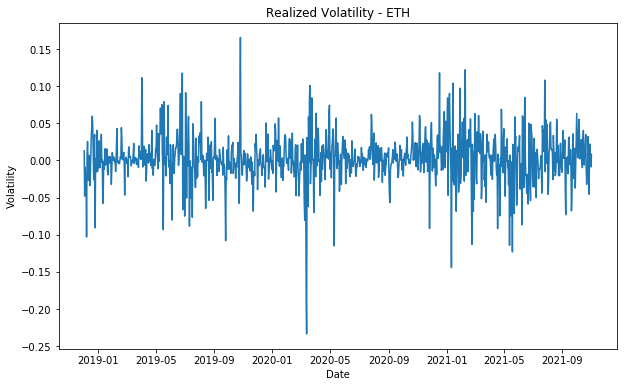

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(d_df[1:].index, d_df['log_return'][1:])
plt.title('Realized Volatility - ETH')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.savefig('images_btc_vola/realized_btc_vol.png')
plt.show()

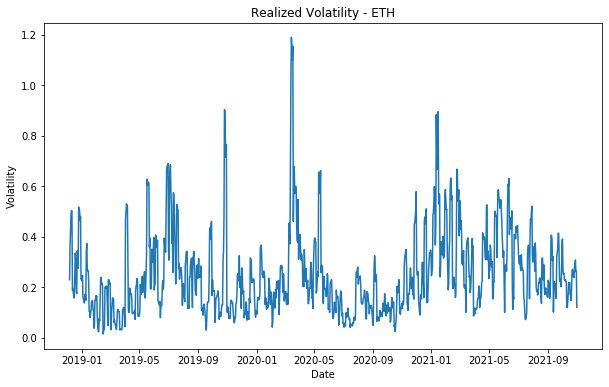

In [11]:
# Log reutn 10x
plt.figure(figsize=(10, 6))
plt.plot(d_df[1:].index, d_df['log_return_10x'][1:].rolling(5).std())
plt.title('Realized Volatility - ETH')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.show()

In [12]:
# Default data
ret = d_df['log_return_10x'][1:] # 10x will Decrease Convergence Effect
retv = ret.values
realized_vol = ret.rolling(5).std()

## ARCH Model

In [ ]:
$\large \sigma = \sqrt{\frac{1}{n-1}\sum_{i=1}^{n}(\bar{r}-r_i)^{2}} $
<br><br> 

$\large \sigma_t^{2} = \sum_{k=1}^p{\alpha_k}(r_{t-k})^2 $
<br><br>
p: จำนวนของ Lag residual errors
<br><br>สมการนี้บอกเราว่า ARCH เป็นแบบจำลองที่ไม่แปรผัน (Unvariate) และไม่เป็นเชิงเส้น (Non-linear) ซึ่งประมาณการความผันผวนด้วยกำลังสองของผลตอบแทนที่ผ่านมา (Squared of past returns) (ทั้งนี้ ARCH ใช้ได้เฉพาะ Stationary เท่านั้น)

In [13]:
n = 252
split_date = ret.iloc[-n:].index
sgm2 = ret.var()
K = ret.kurtosis()
alpha = (-3.0 * sgm2 + np.sqrt(9.0 * sgm2 ** 2 - 12.0 * (3.0 * sgm2 - K) * K)) / (6 * K)
omega = (1 - alpha) * sgm2
initial_parameters = [alpha, omega]
omega, alpha

(0.044108664904194135, 0.5560587211239502)

In [14]:
@jit(nopython=True, parallel=True)
def arch_likelihood(initial_parameters, retv):
    omega = abs(initial_parameters[0])
    alpha = abs(initial_parameters[1])
    T = len(retv)
    logliks = 0
    sigma2 = np.zeros(T)
    sigma2[0] = np.var(retv)
    for t in range(1, T):
        sigma2[t] = omega + alpha * (retv[t - 1]) ** 2
    logliks = np.sum(0.5 * (np.log(sigma2)+retv ** 2 / sigma2))
    return logliks

In [15]:
logliks = arch_likelihood(initial_parameters, retv)
logliks

-215.61147866975668

In [16]:
def opt_params(x0, retv):
    opt_result = opt.minimize(arch_likelihood, x0=x0, args = (retv),
                                        method='Nelder-Mead', options={'maxiter': 5000})
    params = opt_result.x
    print('\nResults of Nelder-Mead minimization\n{}\n{}'.format(''.join(['-'] * 28), opt_result))
    print('\nResulting params = {}'.format(params))
    return params

In [17]:
params = opt_params(initial_parameters, retv)


Results of Nelder-Mead minimization
----------------------------
 final_simplex: (array([[-0.07308356,  0.30121759],
       [-0.07308152,  0.30129284],
       [-0.07307515,  0.30129819]]), array([-736.6837468 , -736.68374665, -736.6837464 ]))
           fun: -736.68374679726
       message: 'Optimization terminated successfully.'
          nfev: 105
           nit: 55
        status: 0
       success: True
             x: array([-0.07308356,  0.30121759])

Resulting params = [-0.07308356  0.30121759]


In [18]:
def arch_apply(ret):
    omega = params[0]
    alpha = params[1]
    T = len(ret)
    sigma2_arch = np.zeros(T + 1)
    sigma2_arch[0] = np.var(ret)
    for t in range(1, T):
        sigma2_arch[t] = omega + alpha * ret[t - 1] ** 2
    return sigma2_arch

In [19]:
sigma2_arch = arch_apply(ret)

In [20]:
arch = arch_model(ret, mean='zero', vol='ARCH', p=1).fit(disp='off')
print(arch.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:         log_return_10x   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                       ARCH   Log-Likelihood:               -242.948
Distribution:                  Normal   AIC:                           489.895
Method:            Maximum Likelihood   BIC:                           499.839
                                        No. Observations:                 1066
Date:                Tue, Nov 23 2021   Df Residuals:                     1066
Time:                        00:05:43   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0731  8.354e-03      8.747  2.183e-18 [5.

Bayesian Information Criteria (BIC) เพื่อเลือก Order (p) ที่เหมาะสมที่สุด

In [21]:
bic_arch = []
for p in range(1, 5):
    arch = arch_model(ret, mean='zero', vol='ARCH', p=p).fit(disp='off')
    bic_arch.append(arch.bic)
    if arch.bic == np.min(bic_arch):
        best_param = p
arch = arch_model(ret, mean='zero', vol='ARCH', p=best_param).fit(disp='off')
print(arch.summary())
forecast = arch.forecast(start=split_date[0])
forecast_arch = forecast

                        Zero Mean - ARCH Model Results                        
Dep. Variable:         log_return_10x   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                       ARCH   Log-Likelihood:               -195.039
Distribution:                  Normal   AIC:                           400.079
Method:            Maximum Likelihood   BIC:                           424.937
                                        No. Observations:                 1066
Date:                Tue, Nov 23 2021   Df Residuals:                     1066
Time:                        00:05:45   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0374  8.141e-03      4.593  4.376e-06 [2.

In [22]:
rmse_arch = np.sqrt(mean_squared_error(realized_vol[-n:] / 100,
                               np.sqrt(forecast_arch.variance.iloc[-len(split_date):] / 100)))
print('The RMSE value of ARCH model is {:.4f}'.format(rmse_arch))

The RMSE value of ARCH model is 0.0315


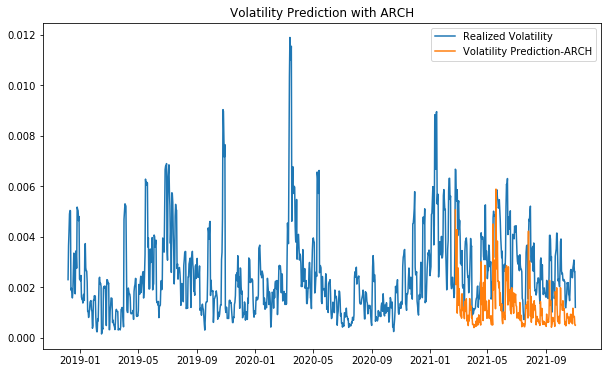

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_arch.variance.iloc[-len(split_date):] / 100, label='Volatility Prediction-ARCH')
plt.title('Volatility Prediction with ARCH', fontsize=12)
plt.legend()
plt.savefig('images_btc_vola/arch_btc_vol.png')
plt.show()

## GARCH Model

GARCH เป็นส่วนขยายของ ARCH ซึ่งโดย GARCH จะพิจารณาผลจาก Variance Lag (p) เพิ่มเข้ามาด้วย ทั้งนี้ q ของ GARCH ก็คือ p ของ ARCH ก่อนหน้านี้นั่นเอง
<br><br>
$ \large {\sigma_t}^2 = \omega + \sum_{k=1}^{q}{\alpha_k}{r^{2}_{t-k}} + \sum_{k=1}^{p}{\beta_k}{\alpha^{2}_{t-k}} $
<br><br>
โดยที่ ω, β และ α เป็นพารามิเตอร์ที่จะประมาณค่า และ q และ p ของ Maximum Lag ในโมเดล

In [24]:
a0 = 0.0001
sgm2 = ret.var()
K = ret.kurtosis()
h = 1 - alpha / sgm2
alpha = np.sqrt(K * (1 - h ** 2) / (2.0 * (K + 3)))
beta = np.abs(h - omega)
omega = (1 - omega) * sgm2
initial_parameters = np.array([omega, alpha, beta])
print('Initial parameters for omega, alpha, and beta  are \n{}\n{}\n{}'.format(omega, alpha, beta))

Initial parameters for omega, alpha, and beta  are 
0.09497447655985095
nan
4.640682950753286


In [25]:
@jit(nopython=True, parallel=True)
def garch_likelihood(initial_parameters, retv):
    omega = initial_parameters[0]
    alpha = initial_parameters[1]
    beta = initial_parameters[2]
    T =  len(retv)
    logliks = 0
    sigma2 = np.zeros(T)
    sigma2[0] = np.var(retv)
    for t in range(1, T):
        sigma2[t] = omega + alpha * (retv[t - 1]) ** 2 + beta * sigma2[t-1]
    logliks = np.sum(0.5 * (np.log(sigma2) + retv ** 2 / sigma2))
    return logliks 

In [26]:
logliks = garch_likelihood(initial_parameters, retv)
print('The Log likelihood  is {:.4f}'.format(logliks))

The Log likelihood  is nan


In [27]:
def garch_constraint(initial_parameters):
    alpha = initial_parameters[0]
    gamma = initial_parameters[1]
    beta = initial_parameters[2]
    return np.array([1 - alpha - beta])

In [28]:
bounds = [(0.0, 1.0), (0.0, 1.0), (0.0, 1.0)]

In [29]:
def opt_paramsG(initial_parameters, retv):
    opt_result = opt.minimize(garch_likelihood,
                                       x0=initial_parameters,
                                       constraints=np.array([1 - alpha - beta]),
                                       bounds=bounds, args = (retv),
                                       method='Nelder-Mead',
                                       options={'maxiter': 5000})
    params = opt_result.x
    print('\nResults of Nelder-Mead minimization\n{}\n{}'.format('-' * 35, opt_result))
    print('-' * 35)
    print('\nResulting parameters = {}'.format(params))
    return params

In [30]:
params = opt_paramsG(initial_parameters, retv)


Results of Nelder-Mead minimization
-----------------------------------
 final_simplex: (array([[0.09497448,        nan, 4.64068295],
       [0.09497448,        nan, 4.64068295],
       [0.09497448,        nan, 4.64068295],
       [0.09497448,        nan, 4.64068295]]), array([nan, nan, nan, nan]))
           fun: nan
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 24999
           nit: 5000
        status: 2
       success: False
             x: array([0.09497448,        nan, 4.64068295])
-----------------------------------

Resulting parameters = [0.09497448        nan 4.64068295]


In [31]:
def garch_apply(ret):
    omega = params[0]
    alpha = params[1]
    beta = params[2]
    T = len(ret)
    sigma2 = np.zeros(T + 1)
    sigma2[0] = np.var(ret)
    for t in range(1, T):
        sigma2[t] = omega + alpha * ret[t - 1] ** 2 + beta * sigma2[t-1]
    return sigma2

In [32]:
garch = arch_model(ret, mean='zero', vol='GARCH', p=1, o=0, q=1).fit(disp='off')
print(garch.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:         log_return_10x   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -191.843
Distribution:                  Normal   AIC:                           389.686
Method:            Maximum Likelihood   BIC:                           404.601
                                        No. Observations:                 1066
Date:                Tue, Nov 23 2021   Df Residuals:                     1066
Time:                        00:06:12   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      7.9734e-03  3.581e-03      2.227  2.596e-02 [9.

In [33]:
bic_garch = []
for p in range(1, 5):
    for q in range(1, 5):
        garch = arch_model(ret, mean='zero',vol='GARCH', p=p, o=0, q=q).fit(disp='off')
        bic_garch.append(garch.bic)
        if garch.bic == np.min(bic_garch):
            best_param = p, q
garch = arch_model(ret, mean='zero', vol='GARCH',
                              p=best_param[0], o=0, q=best_param[1]).fit(disp='off')
print(garch.summary())
forecast = garch.forecast(start=split_date[0])
forecast_garch = forecast

                       Zero Mean - GARCH Model Results                        
Dep. Variable:         log_return_10x   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -182.148
Distribution:                  Normal   AIC:                           374.295
Method:            Maximum Likelihood   BIC:                           399.153
                                        No. Observations:                 1066
Date:                Tue, Nov 23 2021   Df Residuals:                     1066
Time:                        00:06:14   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      9.6213e-03  5.256e-03      1.830  6.718e-02 

In [34]:
rmse_garch = np.sqrt(mean_squared_error(realized_vol[-n:] / 100,
                                np.sqrt(forecast_garch.variance.iloc[-len(split_date):] / 100)))
print('The RMSE value of GARCH model is {:.4f}'.format(rmse_garch))

The RMSE value of GARCH model is 0.0312


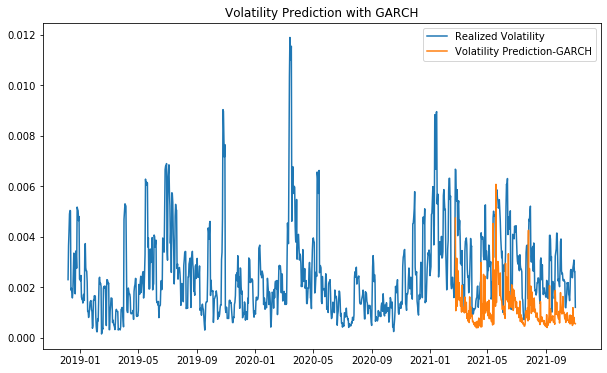

In [35]:
plt.figure(figsize=(10,6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_garch.variance.iloc[-len(split_date):] / 100, label='Volatility Prediction-GARCH')
plt.title('Volatility Prediction with GARCH', fontsize=12)
plt.legend()
plt.savefig('images_btc_vola/garch_btc_vol.png')
plt.show()

## GJR-GARCH

โมเดลนี้ทำงานได้ดีในการสร้างแบบจำลองผลกระทบที่ไม่สมมาตรของ Announcements ในลักษณะที่ข่าวร้าย (Negative Shock) มีผลกระทบมากกว่าข่าวดี (Positive Shock)
<br><br>
$ \large {\sigma_t}^2 = \omega + \sum_{k=1}^{q}({\alpha_k}{r^{2}_{t-k}} + {\gamma}{r^{2}_{t-k}}I(e_{t-1}<0))  + \sum_{k=1}^{p}{\beta_k}{\alpha^{2}_{t-k}} $
<br><br>

In [36]:
bic_gjr_garch = []
for p in range(1, 5):
    for q in range(1, 5):
        gjrgarch = arch_model(ret, mean='zero', p=p, o=1, q=q).fit(disp='off')
        bic_gjr_garch.append(gjrgarch.bic)
        if gjrgarch.bic == np.min(bic_gjr_garch):
            best_param = p, q
gjrgarch = arch_model(ret,mean='zero', p=best_param[0], o=1, q=best_param[1]).fit(disp='off')
print(gjrgarch.summary())
forecast = gjrgarch.forecast(start=split_date[0])
forecast_gjrgarch = forecast

                     Zero Mean - GJR-GARCH Model Results                      
Dep. Variable:         log_return_10x   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                  GJR-GARCH   Log-Likelihood:               -181.569
Distribution:                  Normal   AIC:                           375.139
Method:            Maximum Likelihood   BIC:                           404.969
                                        No. Observations:                 1066
Date:                Tue, Nov 23 2021   Df Residuals:                     1066
Time:                        00:06:21   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      9.2738e-03  5.146e-03      1.802  7.152e-02 

In [37]:
rmse_gjr_garch = np.sqrt(mean_squared_error(realized_vol[-n:] / 100,
                                      np.sqrt(forecast_gjrgarch.variance.iloc[-len(split_date):] / 100)))
print('The RMSE value of GJR-GARCH models is {:.4f}'.format(rmse_gjr_garch))

The RMSE value of GJR-GARCH models is 0.0310


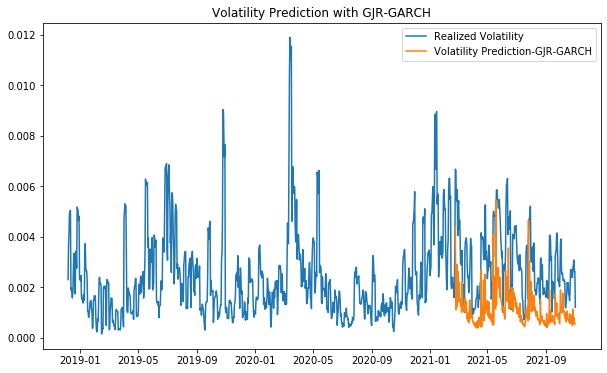

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_gjrgarch.variance.iloc[-len(split_date):] / 100,
           label='Volatility Prediction-GJR-GARCH')
plt.title('Volatility Prediction with GJR-GARCH', fontsize=12)
plt.legend()
plt.savefig('images_btc_vola/gjr_garch_btc_vol.png')
plt.show()

## EGARCH

<br><br>
$ \large \log({\sigma_t}^2) = \omega + \sum_{k=1}^{p}{\beta_k}{log{\sigma^2_{t-k}}}+   
\sum_{k=1}^{q}{\alpha_i}{\frac{|{r_{k-1}}|}{\sqrt{\sigma^2_{t-k}}}} + \sum_{k=1}^{q}{\gamma_k}{\frac{{r_{k-1}}}{\sqrt{\sigma^2_{t-k}}}}
 $
<br><br>

In [39]:
bic_egarch = []
for p in range(1, 5):
    for q in range(1, 5):
        egarch = arch_model(ret, mean='zero', vol='EGARCH', p=p, q=q).fit(disp='off')
        bic_egarch.append(egarch.bic)
        if egarch.bic == np.min(bic_egarch):
            best_param = p, q
egarch = arch_model(ret, mean='zero', vol='EGARCH',
                                p=best_param[0], q=best_param[1]).fit(disp='off')
print(egarch.summary())
forecast = egarch.forecast(start=split_date[0])
forecast_egarch = forecast

                       Zero Mean - EGARCH Model Results                       
Dep. Variable:         log_return_10x   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                     EGARCH   Log-Likelihood:               -169.524
Distribution:                  Normal   AIC:                           349.048
Method:            Maximum Likelihood   BIC:                           373.906
                                        No. Observations:                 1066
Date:                Tue, Nov 23 2021   Df Residuals:                     1066
Time:                        00:06:28   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega         -0.2337      0.125     -1.876  6.061e-02 [ -0.478,

In [40]:
rmse_egarch = np.sqrt(mean_squared_error(realized_vol[-n:] / 100,
                                  np.sqrt(forecast_egarch.variance.iloc[-len(split_date):] / 100)))
print('The RMSE value of EGARCH models is {:.4f}'.format(rmse_egarch))

The RMSE value of EGARCH models is 0.0337


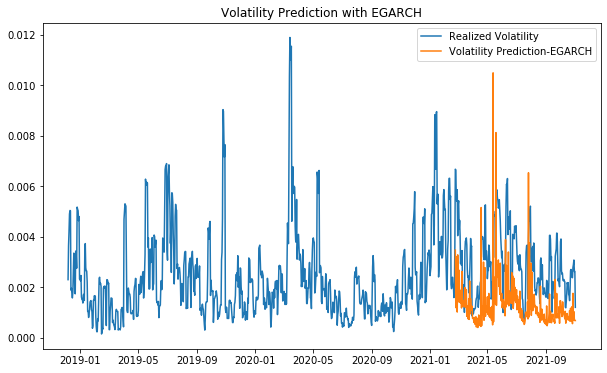

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_egarch.variance.iloc[-len(split_date):] / 100,
           label='Volatility Prediction-EGARCH')
plt.title('Volatility Prediction with EGARCH', fontsize=12)
plt.legend()
plt.savefig('images_btc_vola/egarch_btc_vol.png')
plt.show()

## Support Vector Regression-GARCH

สำหรับ Regression จุดมุ่งหมายคือการหา Hyperplane ที่ลดข้อผิดพลาดให้เหลือน้อยที่สุดและเพิ่มระยะขอบให้สูงสุด <b> Max margin, Min Error </b> โดยในส่วนนี้ เราจะประยุกต์ใช้ SVR ควบคู่กับโมเดล GARCH

In [42]:
from sklearn.svm import SVR
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error

In [43]:
realized_vol = ret.rolling(5).std()
realized_vol = pd.DataFrame(realized_vol)
realized_vol.reset_index(drop=True, inplace=True)

In [44]:
returns_svm = ret ** 2
returns_svm = returns_svm.reset_index()
del returns_svm['ct']

In [45]:
X = pd.concat([realized_vol, returns_svm], axis=1, ignore_index=True)
X = X[4:].copy()
X = X.reset_index()
X.drop('index', axis=1, inplace=True)

In [46]:
realized_vol = realized_vol.dropna().reset_index()
realized_vol.drop('index', axis=1, inplace=True)

In [47]:
svr_poly = SVR(kernel='poly', degree=2)
svr_lin = SVR(kernel='linear')
svr_rbf = SVR(kernel='rbf')

In [48]:
para_grid = {'gamma': sp_rand(), 'C': sp_rand(), 'epsilon': sp_rand()}
clf = RandomizedSearchCV(svr_lin, para_grid)
clf.fit(X.iloc[:-n].values, realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_lin = clf.predict(X.iloc[-n:])

In [49]:
predict_svr_lin = pd.DataFrame(predict_svr_lin)
predict_svr_lin.index = ret.iloc[-n:].index

In [50]:
rmse_svr = np.sqrt(mean_squared_error(realized_vol.iloc[-n:] / 100, predict_svr_lin / 100))
print('The RMSE value of SVR with Linear Kernel is {:.6f}'.format(rmse_svr))

The RMSE value of SVR with Linear Kernel is 0.000114


In [51]:
realized_vol.index = ret.iloc[4:].index

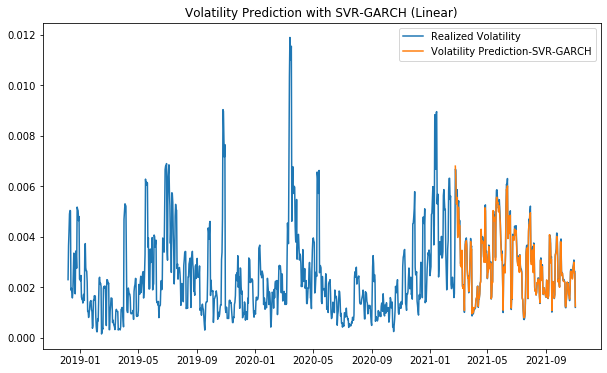

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(predict_svr_lin / 100, label='Volatility Prediction-SVR-GARCH')
plt.title('Volatility Prediction with SVR-GARCH (Linear)', fontsize=12)
plt.legend()
plt.savefig('images_btc_vola/svr_garch_linear_btc_vol.png')
plt.show()

In [53]:
para_grid ={'gamma': sp_rand(), 'C': sp_rand(), 'epsilon': sp_rand()}
clf = RandomizedSearchCV(svr_rbf, para_grid)
clf.fit(X.iloc[:-n].values, realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_rbf = clf.predict(X.iloc[-n:])

In [54]:
predict_svr_rbf = pd.DataFrame(predict_svr_rbf)
predict_svr_rbf.index = ret.iloc[-n:].index

In [55]:
rmse_svr_rbf = np.sqrt(mean_squared_error(realized_vol.iloc[-n:] / 100, predict_svr_rbf / 100))
print('The RMSE value of SVR with RBF Kernel is  {:.6f}'.format(rmse_svr_rbf))

The RMSE value of SVR with RBF Kernel is  0.000257


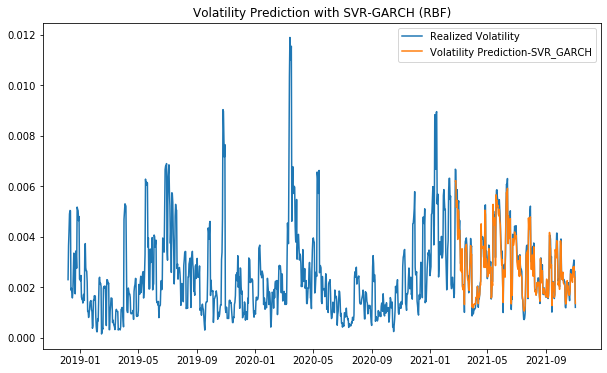

In [56]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(predict_svr_rbf / 100, label='Volatility Prediction-SVR_GARCH')
plt.title('Volatility Prediction with SVR-GARCH (RBF)', fontsize=12)
plt.legend()
plt.savefig('images_btc_vola/svr_garch_rbf_btc_vol.png')
plt.show()

In [57]:
para_grid = {'gamma': sp_rand(), 'C': sp_rand(), 'epsilon': sp_rand()}
clf = RandomizedSearchCV(svr_poly, para_grid)
clf.fit(X.iloc[:-n].values, realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_poly = clf.predict(X.iloc[-n:])

In [58]:
predict_svr_poly = pd.DataFrame(predict_svr_poly)
predict_svr_poly.index = ret.iloc[-n:].index

In [59]:
rmse_svr_poly = np.sqrt(mean_squared_error(realized_vol.iloc[-n:] / 100, 
                                    predict_svr_poly / 100))
print('The RMSE value of SVR with Polynomial Kernel is {:.6f}'.format(rmse_svr_poly))

The RMSE value of SVR with Polynomial Kernel is 0.000524


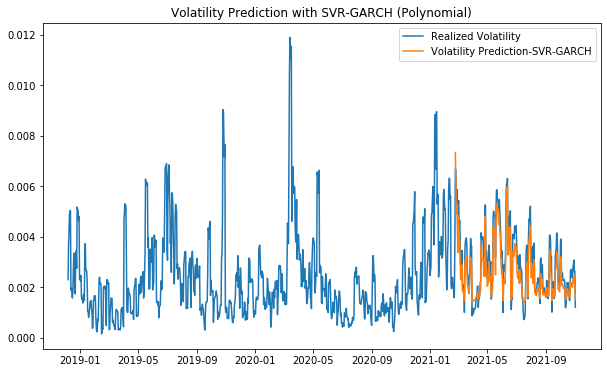

In [60]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol/100, label='Realized Volatility')
plt.plot(predict_svr_poly/100, label='Volatility Prediction-SVR-GARCH')
plt.title('Volatility Prediction with SVR-GARCH (Polynomial)', fontsize=12)
plt.legend()
plt.savefig('images_btc_vola/svr_garch_poly_btc_vol.png')
plt.show()

## Neural Network

$ \large z = \omega_1 x_1 + \omega_2 x_2 + ... + b $
<br><br>
โดยเราจะใช้ Gradient Descent เพื่อหา $ (w, b) $ จากฟังก์ชั่น $ \theta(w, b) $ มาอัพเดทสมการ จนกว่าจะได้สมการที่ Minimize กับ Cost Function (J) ที่สุด โดยฟังก์ฺชั่นสำหรับหาค่ามาอัพเดทคือฟังก์ดังต่อไปนี้
<br><br>
$ \large \theta_{t+1} = \theta_t - \lambda \frac{\delta{J}}{\delta{\theta}} $

In [61]:
from sklearn.neural_network import MLPRegressor
NN_vol = MLPRegressor(learning_rate_init=0.001, random_state=1)
para_grid_NN = {'hidden_layer_sizes': [(100, 50), (50, 50), (10, 100)],
                          'max_iter': [500, 1000],
                          'alpha': [0.00005, 0.0005 ]}
clf = RandomizedSearchCV(NN_vol, para_grid_NN)
clf.fit(X.iloc[:-n].values, realized_vol.iloc[1:-(n-1)].values.reshape(-1, ))
NN_predictions = clf.predict(X.iloc[-n:])

In [62]:
NN_predictions = pd.DataFrame(NN_predictions)
NN_predictions.index = ret.iloc[-n:].index

In [63]:
rmse_NN = np.sqrt(mean_squared_error(realized_vol.iloc[-n:] / 100, NN_predictions / 100))
print('The RMSE value of NN is {:.6f}'.format(rmse_NN))

The RMSE value of NN is 0.000240


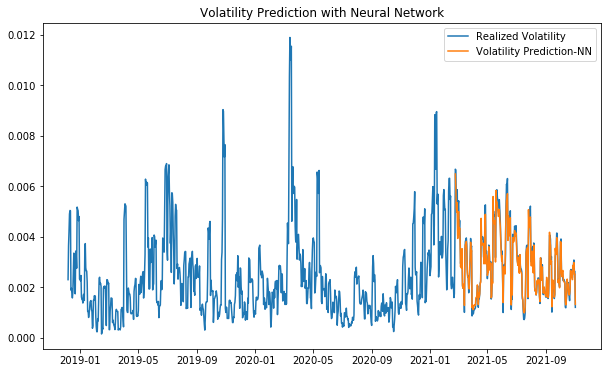

In [64]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(NN_predictions / 100, label='Volatility Prediction-NN')
plt.title('Volatility Prediction with Neural Network', fontsize=12)
plt.legend()
plt.savefig('images_btc_vola/NN_btc_vol.png')
plt.show()

In [65]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([layers.Dense(256, activation="relu"),
                                       layers.Dense(128, activation="relu"),
                                       layers.Dense(1, activation="linear"),])
model.compile(loss='mse', optimizer='rmsprop')
epochs_trial = np.arange(100, 400, 4)
batch_trial = np.arange(100, 400, 4)
DL_pred = []
DL_RMSE = []
for i, j, k in zip(range(4), epochs_trial, batch_trial):
    model.fit(X.iloc[:-n].values,
                  realized_vol.iloc[1:-(n-1)].values.reshape(-1,),
                  batch_size=k, epochs=j, verbose=False)
    DL_predict = model.predict(np.asarray(X.iloc[-n:]))
    DL_RMSE.append(np.sqrt(mean_squared_error(realized_vol.iloc[-n:] / 100,
                               DL_predict.flatten() / 100)))
    DL_pred.append(DL_predict)
    print('DL_RMSE_{}:{:.6f}'.format(i+1, DL_RMSE[i]))

DL_RMSE_1:0.000799
DL_RMSE_2:0.000348
DL_RMSE_3:0.000280
DL_RMSE_4:0.000269


In [66]:
DL_predict = pd.DataFrame(DL_pred[DL_RMSE.index(min(DL_RMSE))])
DL_predict.index = ret.iloc[-n:].index

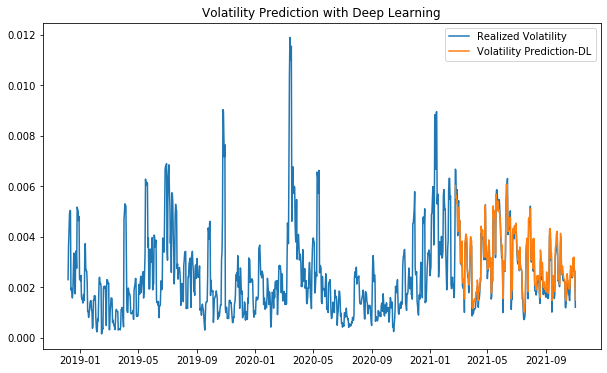

In [67]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100,label='Realized Volatility')
plt.plot(DL_predict / 100,label='Volatility Prediction-DL')
plt.title('Volatility Prediction with Deep Learning',  fontsize=12)
plt.legend()
plt.savefig('images_btc_vola/DL_btc_vol.png')
plt.show()